https://towardsdatascience.com/word2vec-with-pytorch-implementing-original-paper-2cd7040120b0

In [401]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import WikiText2
import pandas as pd
from nltk.corpus import brown
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import sys
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import os


In [192]:
from torchtext.datasets import WikiText2
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import dataset

# train_iter = WikiText2(split='train')
# tokenizer = get_tokenizer('basic_english')
# vocab1 = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
# vocab1.set_default_index(vocab['<unk>'])
from datasets import load_dataset
wikitext2 = load_dataset("wikitext", "wikitext-2-v1")


In [239]:
text = wikitext2["train"]['text']
text = [item.lower().strip() for item in text if len(item) > 0]
len(text)

23767

In [240]:
text = [item.split(" ") + ["\n"] for item in text if "=" not in item]

In [352]:
# Prepare Corpus
DATA_LIMIT = 3000 #paragraph limit
all_words = []
for paragraph in text[:DATA_LIMIT]:
    all_words += paragraph
all_words = pd.Series(all_words)
len(all_words)

331195

In [353]:
len(all_words.unique())

17092

In [354]:
#filter out rare words
N_times = 50
v_counts = all_words.value_counts()
corpus = pd.Series([key for key in v_counts.keys() if v_counts[key] >= N_times])
corpus

0            the
1              ,
2              .
3          <unk>
4             of
         ...    
716    catechism
717     designed
718      english
719     followed
720      decided
Length: 721, dtype: object

In [355]:
def tensor_to_array(t):
    return np.array([i.item() for i in list(t)])

### Old NLTK Dataset

In [356]:
# brown_news_tagged = brown.tagged_words(categories='news', tagset='universal')
# print(len(pd.Series(brown_news_tagged).unique()))
# len(brown.words())

In [357]:
# Prepare Corpus
# DATA_LIMIT = 25000

# remove_punc = [word for word in brown_news_tagged]
# text = pd.Series([word[0].lower() for word in remove_punc][:DATA_LIMIT])
# len(text)

In [358]:
# #filter out rare words
# N_times = 25
# v_counts = text.value_counts()
# corpus = pd.Series([key for key in v_counts.keys() if v_counts[key] >= N_times])
# len(corpus)


### Continuing

In [359]:
vocab = {}
for i in range(len(corpus)):
    vocab[corpus[i]] = i
len(vocab)

721

In [361]:
enc_text = [[vocab[word] if word in vocab else vocab["<unk>"] for word in paragraph] for paragraph in text]
len(enc_text)

[[3,
  109,
  665,
  95,
  50,
  3,
  3,
  22,
  3,
  50,
  3,
  1,
  3,
  2,
  665,
  4,
  0,
  3,
  95,
  21,
  1,
  3,
  3,
  7,
  14,
  665,
  3,
  667,
  618,
  3,
  1,
  19,
  8,
  3,
  382,
  11,
  528,
  323,
  91,
  509,
  20,
  3,
  5,
  3,
  15,
  0,
  3,
  3,
  2,
  168,
  6,
  327,
  325,
  6,
  3,
  1,
  25,
  19,
  0,
  290,
  91,
  6,
  0,
  665,
  157,
  2,
  3,
  0,
  162,
  3,
  4,
  3,
  5,
  3,
  11,
  60,
  3,
  14,
  51,
  3,
  1,
  0,
  348,
  3,
  3,
  7,
  0,
  49,
  91,
  5,
  3,
  0,
  9,
  3,
  9,
  1,
  8,
  3,
  184,
  3,
  3,
  0,
  3,
  4,
  3,
  59,
  0,
  103,
  3,
  78,
  53,
  3,
  3,
  159,
  409,
  5,
  33,
  3,
  126,
  0,
  3,
  3,
  9,
  3,
  3,
  9,
  2,
  12],
 [0,
  91,
  145,
  588,
  6,
  316,
  1,
  3,
  72,
  8,
  273,
  3,
  4,
  0,
  148,
  3,
  17,
  665,
  3,
  373,
  2,
  75,
  25,
  3,
  0,
  3,
  3,
  4,
  0,
  157,
  1,
  25,
  39,
  3,
  3,
  3,
  1,
  100,
  14,
  564,
  0,
  91,
  64,
  3,
  15,
  157,
  3,
  2,
  415,
  3,
  

In [362]:
SCANNING_WINDOW = 4
#maybe need to split into paragraphs b/c different topics...
#returns context, middle word
def get_data(index, window, data):
    return list(data[index-window:index])+list(data[index+1:index+window+1]), data[index]

In [363]:
x = []
y = []
for paragraph in enc_text:
    for i in range(SCANNING_WINDOW, len(paragraph) - SCANNING_WINDOW):
        if paragraph[i] == vocab["<unk>"]:
            continue
        a, b = get_data(i, SCANNING_WINDOW, paragraph)
        x.append(a)
        y.append(b)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=5)
len(x_train) + len(x_test)

1225000

In [402]:
def save_model(model, name="model"):
        """Save final model to `self.model_dir` directory"""
        model_path = os.path.join("model", name+".pt")
        torch.save(model, model_path)

In [368]:
EMBED_DIMENSION = 50
EMBED_MAX_NORM = 1
class Net_CBOW(nn.Module):
    def __init__(self, vocab_size: int):
        super(Net_CBOW, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=EMBED_DIMENSION,
            max_norm=EMBED_MAX_NORM,
        )
        self.linear = nn.Linear(
            in_features=EMBED_DIMENSION,
            out_features=vocab_size,
        )
    def forward(self, inputs_):
        x = self.embeddings(inputs_)
        x = x.mean(axis=0)
        x = self.linear(x)
        return x

In [372]:
net = Net_CBOW(len(vocab))
params = list(net.parameters())
net.zero_grad()
criterion = nn.CrossEntropyLoss()
losses = []

In [373]:
NUM_EPOCHS = 20

optimizer = optim.Adam(net.parameters(), lr=0.025)
scheduler = optim.lr_scheduler.LinearLR(optimizer, 1.0, 0.0, total_iters=NUM_EPOCHS, verbose=True)

In [374]:

for epoch in range(NUM_EPOCHS):
    print("RUN", str(epoch+1)+"/"+str(NUM_EPOCHS), end=": ")
    for index in range(len(x_train)):
        if index % (len(x_train)//100) == 0:
            print("•", end="")

        context, target = x_train[index], y_train[index]
        optimizer.zero_grad()   # zero the gradient buffers
        output = net(torch.tensor(context))
        loss = criterion(output, torch.tensor(target))
        loss.backward()
        optimizer.step()    # Does the update

    for context, target in zip(x_test, y_test):
        output = net(torch.tensor(context))
        losses.append(criterion(output, torch.tensor(target)).item())
    print(scheduler.get_last_lr())

    scheduler.step()
    print()

RUN 1/20: ••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••[0.025]

RUN 2/20: ••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••[0.02375]

RUN 3/20: ••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••[0.022500000000000003]

RUN 4/20: ••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••[0.02125]

RUN 5/20: ••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••[0.02]

RUN 6/20: ••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••[0.01875]

RUN 7/20: ••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••[0.017499999999999998]

RUN 8/20: ••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••[0.01625]

RUN 9/20: •

In [404]:
save_model(net, "model_april23_3000datalim_10epoch")

In [399]:
loss_per_epoch = []
for i in range(NUM_EPOCHS):
    loss_per_epoch += [sum(losses[(i)*len(x_test):(i+1)*len(x_test)])/len(x_test)]

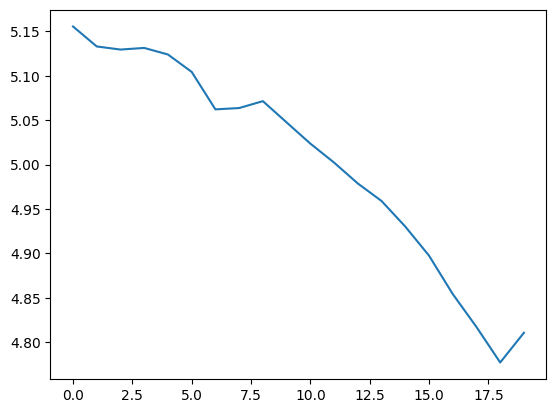

In [400]:
plt.plot(loss_per_epoch)
plt.show()

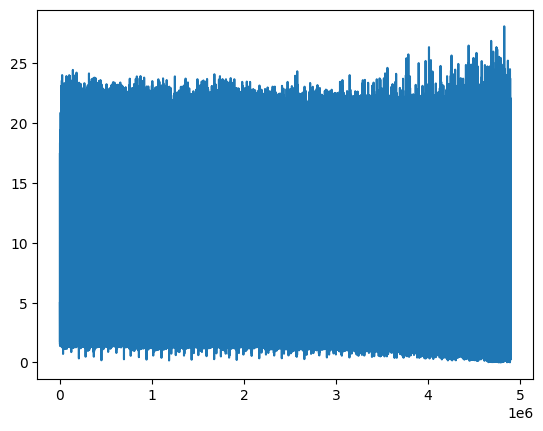

In [375]:
plt.plot(losses)
plt.show()

In [405]:
# get first layer of the model
embeddings = list(net.parameters())[0]
embeddings = embeddings.cpu().detach().numpy()

# normalize the embeddings layer
norms = (embeddings ** 2).sum(axis=1) ** (0.5)
norms = np.reshape(norms, (len(norms), 1))
embeddings_norm = embeddings / norms
embeddings_norm.shape

(721, 50)

In [406]:
embeddings_df = pd.DataFrame(embeddings)

# t-SNE transform
tsne = TSNE(n_components=2)
embeddings_df_tsne = tsne.fit_transform(embeddings_df)
embeddings_df_tsne = pd.DataFrame(embeddings_df_tsne)

embeddings_df_tsne.index = vocab.keys()

In [418]:
numeric = embeddings_df_tsne.index.str.isnumeric()
color = np.where(numeric, "green", "black")
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=embeddings_df_tsne[0],
        y=embeddings_df_tsne[1],
        mode="text",
        text=embeddings_df_tsne.index,
        textposition="middle center",
        textfont=dict(color=color),
    )
)
# fig.write_html("word2vec_visualization.html")
fig

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'text',
              'text': array(['the', ',', '.', ..., 'english', 'followed', 'decided'], dtype=object),
              'textfont': {'color': array(['black', 'black', 'black', ..., 'black', 'black', 'black'], dtype='<U5')},
              'textposition': 'middle center',
              'type': 'scatter',
              'x': array([-13.381476,  17.178057,  17.908615, ...,  11.481327, -12.289429,
                          -13.613183], dtype=float32),
              'y': array([ 6.898983 , 11.837098 , 13.752215 , ..., -7.4247546, 15.102788 ,
                          -9.77928  ], dtype=float32)}],
    'layout': {'template': '...'}
})

In [408]:
def lookup_id(word, vocab=vocab):
    if word not in vocab:
        return vocab["<unk>"]
    return vocab[word]

In [409]:
def lookup_token(word_id, vocab=vocab):
    for word in vocab:
        if vocab[word] == word_id:
            return word
    return None

In [410]:
def get_top_similar(word: str, topN: int = 10):
    if word not in vocab:
        print("Out of vocabulary word")
        return
    word_id = lookup_id(word)

    word_vec = embeddings_norm[word_id]
    word_vec = np.reshape(word_vec, (len(word_vec), 1))
    dists = np.matmul(embeddings_norm, word_vec).flatten()
    topN_ids = np.argsort(-dists)[1 : topN + 1]

    topN_dict = {}
    for sim_word_id in topN_ids:
        # sim_word = vocab.lookup_token(sim_word_id)
        sim_word = "<unk_>"
        for k in vocab:
            if vocab[k] == sim_word_id:
                sim_word = k
                break
        topN_dict[sim_word] = dists[sim_word_id]
    return topN_dict

In [411]:
for word, sim in get_top_similar("one").items():
    print("{}: {:.3f}".format(word, sim))

six: 0.786
the: 0.766
top: 0.728
evidence: 0.723
a: 0.708
week: 0.705
another: 0.705
three: 0.704
number: 0.700
two: 0.690


In [412]:
emb1 = embeddings[vocab["father"]]
emb2 = embeddings[vocab["man"]]
emb3 = embeddings[vocab["female"]]

emb4 = emb1 - emb2 + emb3
emb4_norm = (emb4 ** 2).sum() ** (1 / 2)
emb4 = emb4 / emb4_norm

emb4 = np.reshape(emb4, (len(emb4), 1))
dists = np.matmul(embeddings_norm, emb4).flatten()

top5 = np.argsort(-dists)[:5]

for word_id in top5:
    print("{}: {:.3f}".format(lookup_token(word_id), dists[word_id]))

father: 0.780
female: 0.702
government: 0.679
work: 0.662
fire: 0.656
